In [31]:
import sys

from datasets import DatasetTrain, DatasetVal 

sys.path.append("./model")
from model import Model

sys.path.append("./utils")
from utils import add_weight_decay

import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import cv2

import time
import warnings
warnings.simplefilter('ignore')

In [17]:
model_id = "1"

num_epochs = 10
batch_size = 3
learning_rate = 0.0001

In [18]:
if torch.cuda.is_available():
    network = Model(model_id, project_dir="./").cuda()
else:
    network = Model(model_id, project_dir="./")

pretrained resnet, 18


In [19]:
train_dataset = DatasetTrain(cityscapes_data_path="./data_dir/cityscapes",
                             cityscapes_meta_path="./data_dir/cityscapes/meta")
val_dataset = DatasetVal(cityscapes_data_path="./data_dir/cityscapes",
                         cityscapes_meta_path="./data_dir/cityscapes/meta")

num_train_batches = int(len(train_dataset)/batch_size)
num_val_batches = int(len(val_dataset)/batch_size)
print ("num_train_batches:", num_train_batches)
print ("num_val_batches:", num_val_batches)

('num_train_batches:', 991)
('num_val_batches:', 166)


In [20]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=0)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=batch_size, shuffle=False,
                                         num_workers=0)

params = add_weight_decay(network, l2_value=0.0001)
optimizer = torch.optim.Adam(params, lr=learning_rate)

In [21]:
with open("./data_dir/cityscapes/meta/class_weights.pkl", "rb") as file: 
    class_weights = np.array(pickle.load(file))
class_weights = torch.from_numpy(class_weights)
class_weights = Variable(class_weights.type(torch.FloatTensor))

# loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

In [22]:
epoch_losses_train = []
epoch_losses_val = []

In [23]:
for epoch in range(num_epochs):
    print ("###########################")
    print ("######## NEW EPOCH ########")
    print ("###########################")
    print ("epoch: %d/%d" % (epoch+1, num_epochs))

    network.train() 
    batch_losses = []
    for step, (imgs, label_imgs) in enumerate(train_loader):
        imgs = Variable(imgs) # (shape: (batch_size, 3, img_h, img_w))
        label_imgs = Variable(label_imgs.type(torch.LongTensor)) # (shape: (batch_size, img_h, img_w))

        outputs = network(imgs) # (shape: (batch_size, num_classes, img_h, img_w))

        # compute the loss:
        loss = loss_fn(outputs, label_imgs)
        loss_value = loss.data.cpu().numpy()
        batch_losses.append(loss_value)

        # optimization step:
        optimizer.zero_grad() # (reset gradients)
        loss.backward() # (compute gradients)
        optimizer.step() # (perform optimization step)

    epoch_loss = np.mean(batch_losses)
    epoch_losses_train.append(epoch_loss)
    with open("%s/epoch_losses_train.pkl" % network.model_dir, "wb") as file:
        pickle.dump(epoch_losses_train, file)
    print ("Train loss: %g" % epoch_loss)
    plt.figure(1)
    plt.plot(epoch_losses_train, "k^")
    plt.plot(epoch_losses_train, "k")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.title("Train loss per epoch")
    plt.savefig("%s/epoch_losses_train.png" % network.model_dir)
    plt.close(1)

    print ("####")

    ############################################################################
    # val:
    ############################################################################
    network.eval() 
    batch_losses = []
    for step, (imgs, label_imgs, img_ids) in enumerate(val_loader):
        with torch.no_grad(): 
            imgs = Variable(imgs) # (shape: (batch_size, 3, img_h, img_w))
            label_imgs = Variable(label_imgs.type(torch.LongTensor)) # (shape: (batch_size, img_h, img_w))

            outputs = network(imgs) # (shape: (batch_size, num_classes, img_h, img_w))

            # compute the loss:
            loss = loss_fn(outputs, label_imgs)
            loss_value = loss.data.cpu().numpy()
            batch_losses.append(loss_value)

    epoch_loss = np.mean(batch_losses)
    epoch_losses_val.append(epoch_loss)
    with open("%s/epoch_losses_val.pkl" % network.model_dir, "wb") as file:
        pickle.dump(epoch_losses_val, file)
    print ("Val loss: %g" % epoch_loss)
    plt.figure(1)
    plt.plot(epoch_losses_val, "k^")
    plt.plot(epoch_losses_val, "k")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.title("Val loss per epoch")
    plt.savefig("%s/epoch_losses_val.png" % network.model_dir)
    plt.close(1)

    # save the model weights to disk:
    checkpoint_path = network.checkpoints_dir + "/model_" + model_id +"_epoch_" + str(epoch+1) + ".pth"
    torch.save(network.state_dict(), checkpoint_path)

###########################
######## NEW EPOCH ########
###########################
epoch: 1/10
Train loss: 1.80425
####
Val loss: 1.28603
###########################
######## NEW EPOCH ########
###########################
epoch: 2/10
Train loss: 1.34905
####
Val loss: 1.1592
###########################
######## NEW EPOCH ########
###########################
epoch: 3/10
Train loss: 1.217
####
Val loss: 0.999158
###########################
######## NEW EPOCH ########
###########################
epoch: 4/10
Train loss: 1.14101
####
Val loss: 0.929506
###########################
######## NEW EPOCH ########
###########################
epoch: 5/10
Train loss: 1.0641
####
Val loss: 0.914585
###########################
######## NEW EPOCH ########
###########################
epoch: 6/10
Train loss: 1.02473
####
Val loss: 0.903437
###########################
######## NEW EPOCH ########
###########################
epoch: 7/10
Train loss: 0.966139
####
Val loss: 0.8555
###########################

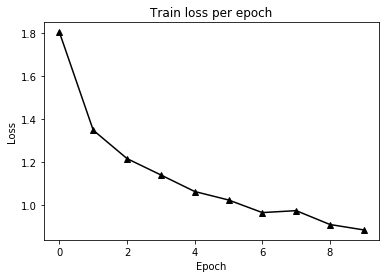

In [37]:
%matplotlib inline
plt.plot(epoch_losses_train, "k^")
plt.plot(epoch_losses_train, "k")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Train loss per epoch")
plt.show()

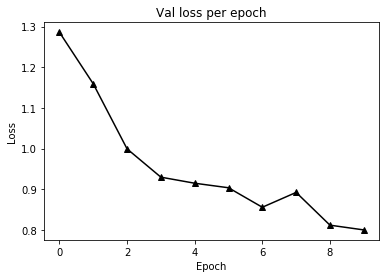

In [39]:
plt.plot(epoch_losses_val, "k^")
plt.plot(epoch_losses_val, "k")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Val loss per epoch")
plt.show()